In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import json
import os
import tensorflow as tf
import sklearn
import seaborn as sbs
import sklearn.naive_bayes
import sklearn.model_selection
import sklearn.metrics

In [13]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify the file path in your Google Drive
file_path = '/content/drive/My Drive/combined_data.csv'

# Load the dataset
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
df.head()

Mounted at /content/drive


,datetime,tweet_id,username,tweet_text,cleaned_text,sarcasm_class
0,2021-05-30 17:03:13+00:00,1399048765491736577,GaglaniNishith,Vaccination slots cowin portal var kadhi open ...,Vaccination slots cowin portal var kadhi open ...,1
1,2021-11-25 10:14:07+00:00,1463813239515475973,Harsh_Tiwari_Ji,Citizen's don't use personal brain that vaccin...,Citizen's don't use personal brain that vaccin...,1
2,2021-05-13 11:04:29+00:00,1392797892163768322,guptagaurav1988,"capt_amarinder’drharshvardhan,PMOIndia,AmitSha...",Please Avail the Covid-19 Vaccine on control ...,0
3,2021-04-19 19:02:51+00:00,1384220971863711746,Ashgem49,JyotiTathgur Pawankhera rajuparulekar All PiDi...,All PiDis should be offered only Pappu’s Mutr...,1
4,2020-12-27 20:15:02+00:00,1343289308132892674,Joseph_Santoro,The Draconian Machinations of Evil Republicans...,The Draconian Machinations of Evil Republicans...,0


In [14]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [15]:
import pandas as pd

# Specify the rows you want to skip (adjust as needed)
rows_to_skip = [1, 2, 3]

# Read the CSV file, skipping the specified rows
df1 = pd.read_csv("/content/drive/My Drive/combined_data.csv", skiprows=rows_to_skip)

# Continue with your DataFrame manipulation
df = pd.concat([df1[['cleaned_text', 'sarcasm_class']]], axis=0)
df.head()

,cleaned_text,sarcasm_class
0,All PiDis should be offered only Pappu’s Mutr...,1
1,The Draconian Machinations of Evil Republicans...,0
2,one of the first lawsuits against 🇨🇳 for the ...,0
3,As u mentioned in last speech micro containme...,0
4,Dawud Osman defends Adofo Muhammad.. “the Covi...,1


In [16]:
import pandas as pd

df1 = pd.read_csv("/content/drive/My Drive/combined_data.csv", skiprows=rows_to_skip)

sentences = df1['cleaned_text'].tolist()
labels = df1['sarcasm_class'].tolist()

#shuffle data to split into train, test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, train_size = 0.8, random_state = 42, shuffle = True)

In [17]:
df1.shape
train_dataframe = df1[0:22895]
test_dataframe = df1[22895:28619]

In [18]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

159997
159997
40000
40000


In [19]:
#tokenize text
vocab_size = 10000
embedding_dim = 16
max_length = 100
training_size = 20000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,maxlen=max_length, padding='post', truncating='post')

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding='post', truncating='post')

In [20]:
training_padded = np.array(training_padded)
training_labels = np.array(y_train)
testing_padded = np.array(testing_padded)
testing_labels = np.array(y_test)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
5000/5000 - 21s - loss: 0.5745 - accuracy: 0.6944 - val_loss: 0.5392 - val_accuracy: 0.7225 - 21s/epoch - 4ms/step
Epoch 2/10
5000/5000 - 20s - loss: 0.5236 - accuracy: 0.7357 - val_loss: 0.5364 - val_accuracy: 0.7263 - 20s/epoch - 4ms/step
Epoch 3/10
5000/5000 - 18s - loss: 0.5138 - accuracy: 0.7438 - val_loss: 0.5375 - val_accuracy: 0.7256 - 18s/epoch - 4ms/step
Epoch 4/10
5000/5000 - 22s - loss: 0.5078 - accuracy: 0.7467 - val_loss: 0.5352 - val_accuracy: 0.7264 - 22s/epoch - 4ms/step
Epoch 5/10
5000/5000 - 18s - loss: 0.5014 - accuracy: 0.7515 - val_loss: 0.5344 - val_accuracy: 0.7290 - 18s/epoch - 4ms/step
Epoch 6/10
5000/5000 - 18s - loss: 0.4945 - accuracy: 0.7572 - val_loss: 0.5354 - val_accuracy: 0.7297 - 18s/epoch - 4ms/step
Epoch 7/10
5000/5000 - 19s - loss: 0.4876 - accuracy: 0.7611 - val_loss: 0.5368 - val_accuracy: 0.7275 - 19s/epoch - 4ms/step
Epoch 8/10
5000/5000 - 21s - loss: 0.4808 - accuracy: 0.7670 - val_loss: 0.5449 - val_accuracy: 0.7255 - 21s/epoch - 4

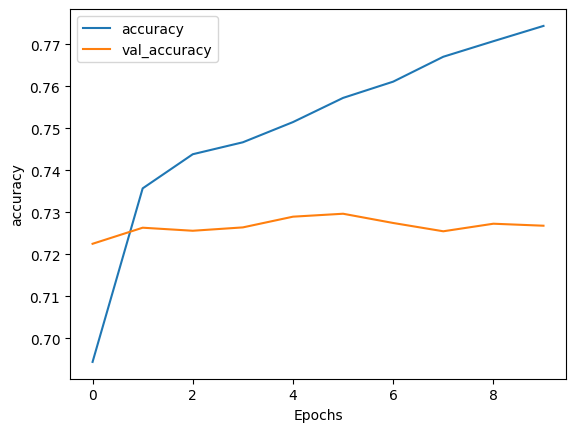

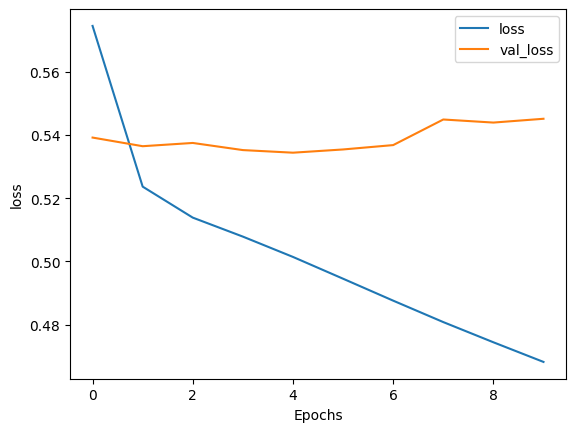

In [21]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [22]:
#CNN Model
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history1 = model1.fit(training_padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
5000/5000 - 51s - loss: 0.5641 - accuracy: 0.7009 - val_loss: 0.5350 - val_accuracy: 0.7272 - 51s/epoch - 10ms/step
Epoch 2/10
5000/5000 - 48s - loss: 0.5136 - accuracy: 0.7432 - val_loss: 0.5307 - val_accuracy: 0.7296 - 48s/epoch - 10ms/step
Epoch 3/10
5000/5000 - 54s - loss: 0.4902 - accuracy: 0.7602 - val_loss: 0.5319 - val_accuracy: 0.7346 - 54s/epoch - 11ms/step
Epoch 4/10
5000/5000 - 49s - loss: 0.4665 - accuracy: 0.7772 - val_loss: 0.5420 - val_accuracy: 0.7284 - 49s/epoch - 10ms/step
Epoch 5/10
5000/5000 - 48s - loss: 0.4403 - accuracy: 0.7933 - val_loss: 0.5527 - val_accuracy: 0.7232 - 48s/epoch - 10ms/step
Epoch 6/10
5000/5000 - 48s - loss: 0.4118 - accuracy: 0.8106 - val_loss: 0.5753 - val_accuracy: 0.7200 - 48s/epoch - 10ms/step
Epoch 7/10
5000/5000 - 48s - loss: 0.3824 - accuracy: 0.8281 - val_loss: 0.6084 - val_accuracy: 0.7143 - 48s/epoch - 10ms/step
Epoch 8/10
5000/5000 - 48s - loss: 0.3552 - accuracy: 0.8433 - val_loss: 0.6394 - val_accuracy: 0.7102 - 48s/ep

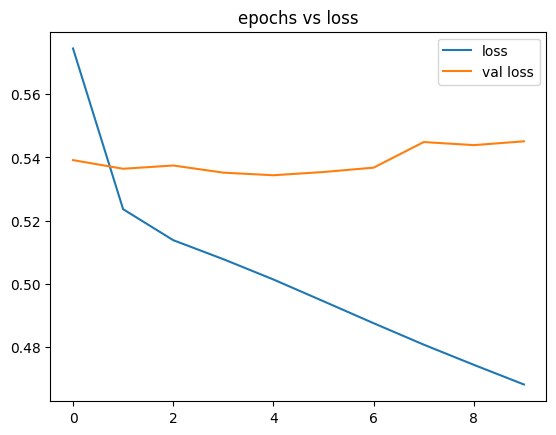

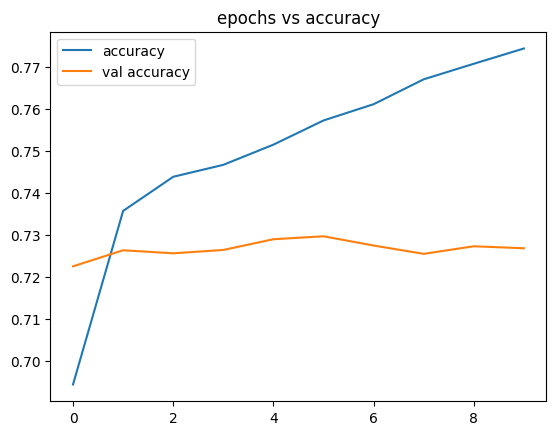

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epoch = history.epoch

plt.plot(epoch,loss, label='loss')
plt.plot(epoch, val_loss, label='val loss')
plt.legend()
plt.title('epochs vs loss')
plt.show()

plt.plot(epoch,acc, label='accuracy')
plt.plot(epoch, val_acc, label='val accuracy')
plt.legend()
plt.title('epochs vs accuracy')
plt.savefig('g1.png')
plt.show()

40/40 [==============================] - 3s 70ms/step


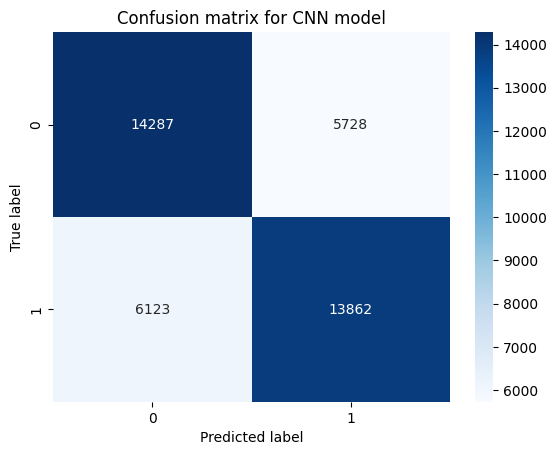

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
batch_size = 1024
y_preds = model1.predict(testing_padded, batch_size=batch_size).round().astype(int)

# Compute the confusion matrix
cm = confusion_matrix(testing_labels, y_preds)

# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix for CNN model')
plt.savefig('confusion_matrix1.png')

# Show the plot
plt.show()

40/40 [==============================] - 3s 68ms/step


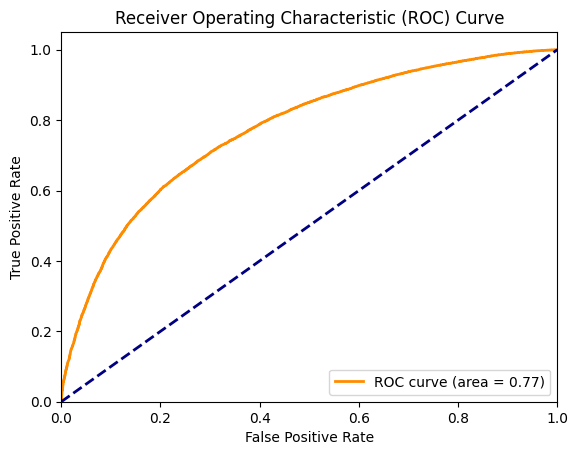

In [25]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the test set
y_prob = model1.predict(testing_padded, batch_size=batch_size)

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(testing_labels, y_prob[:, 0])

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc1.png')


plt.show()

In [26]:
from sklearn.metrics import roc_auc_score
print("Test accuracy score", sklearn.metrics.accuracy_score(y_test, y_preds))
print('Precision= ',sklearn.metrics.precision_score(y_test, y_preds))
print('Recall= ',sklearn.metrics.recall_score(y_test, y_preds))
print('F1 score= ',sklearn.metrics.f1_score(y_test, y_preds))

# Predict probabilities for the test set
y_prob = model1.predict(testing_padded, batch_size=batch_size)

# Calculate AUC
roc_auc = roc_auc_score(testing_labels, y_prob[:, 0])

print('auc= ',roc_auc)

Test accuracy score 0.703725
Precision=  0.7076059213884635
Recall=  0.6936202151613711
F1 score=  0.700543272267846
40/40 [==============================] - 3s 68ms/step
auc=  0.7731250761328552


In [27]:
#LSTM model
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history2 = model2.fit(training_padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
5000/5000 - 314s - loss: 0.5561 - accuracy: 0.7097 - val_loss: 0.5259 - val_accuracy: 0.7340 - 314s/epoch - 63ms/step
Epoch 2/10
5000/5000 - 311s - loss: 0.5002 - accuracy: 0.7537 - val_loss: 0.5248 - val_accuracy: 0.7348 - 311s/epoch - 62ms/step
Epoch 3/10
5000/5000 - 307s - loss: 0.4724 - accuracy: 0.7726 - val_loss: 0.5445 - val_accuracy: 0.7273 - 307s/epoch - 61ms/step
Epoch 4/10
5000/5000 - 312s - loss: 0.4462 - accuracy: 0.7887 - val_loss: 0.5456 - val_accuracy: 0.7309 - 312s/epoch - 62ms/step
Epoch 5/10
5000/5000 - 311s - loss: 0.4169 - accuracy: 0.8055 - val_loss: 0.5628 - val_accuracy: 0.7305 - 311s/epoch - 62ms/step
Epoch 6/10
5000/5000 - 309s - loss: 0.3886 - accuracy: 0.8207 - val_loss: 0.6028 - val_accuracy: 0.7221 - 309s/epoch - 62ms/step
Epoch 7/10
5000/5000 - 311s - loss: 0.3619 - accuracy: 0.8345 - val_loss: 0.6296 - val_accuracy: 0.7168 - 311s/epoch - 62ms/step
Epoch 8/10
5000/5000 - 312s - loss: 0.3377 - accuracy: 0.8471 - val_loss: 0.7050 - val_accuracy: 

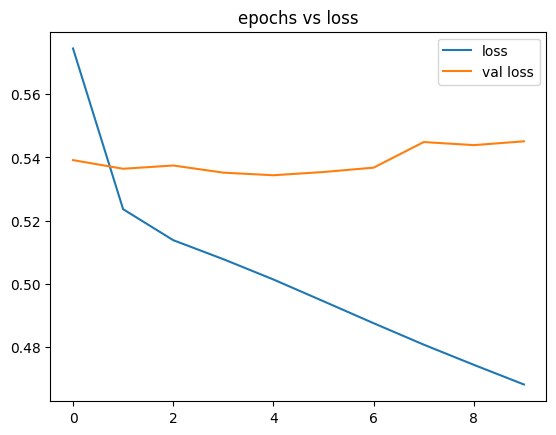

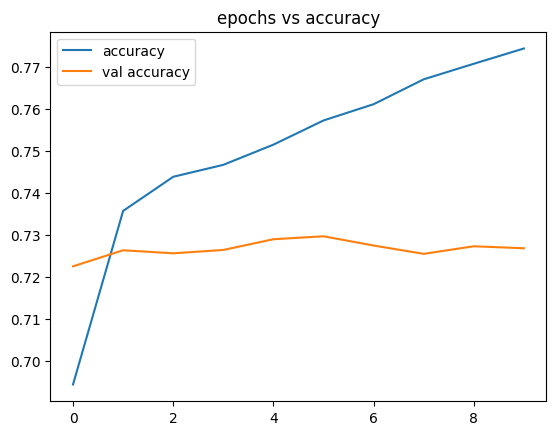

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epoch = history.epoch

plt.plot(epoch,loss, label='loss')
plt.plot(epoch, val_loss, label='val loss')
plt.legend()
plt.title('epochs vs loss')
plt.show()

plt.plot(epoch,acc, label='accuracy')
plt.plot(epoch, val_acc, label='val accuracy')
plt.legend()
plt.title('epochs vs accuracy')
plt.savefig('g2.png')
plt.show()

40/40 [==============================] - 10s 226ms/step


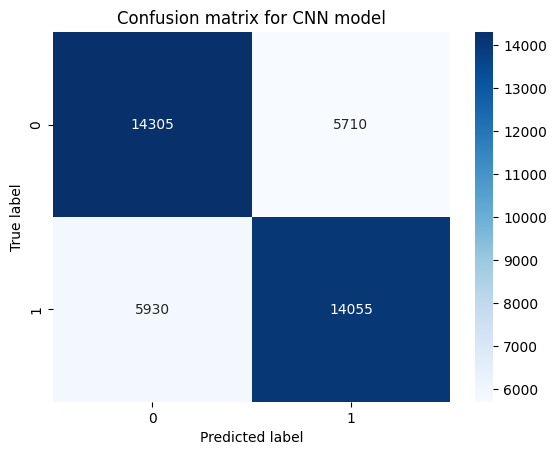

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
batch_size = 1024
y_preds = model2.predict(testing_padded, batch_size=batch_size).round().astype(int)

# Compute the confusion matrix
cm = confusion_matrix(testing_labels, y_preds)

# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix for CNN model')
plt.savefig('confusion_matrix2.png')
# Show the plot
plt.show()

40/40 [==============================] - 3s 68ms/step


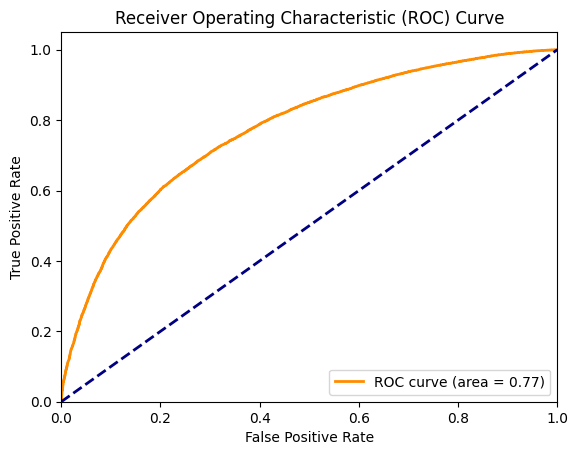

In [30]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the test set
y_prob = model1.predict(testing_padded, batch_size=batch_size)

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(testing_labels, y_prob[:, 0])

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc2.png')

plt.show()

In [31]:
from sklearn.metrics import roc_auc_score
print("Test accuracy score", sklearn.metrics.accuracy_score(y_test, y_preds))
print('Precision= ',sklearn.metrics.precision_score(y_test, y_preds))
print('Recall= ',sklearn.metrics.recall_score(y_test, y_preds))
print('F1 score= ',sklearn.metrics.f1_score(y_test, y_preds))

# Predict probabilities for the test set
y_prob = model1.predict(testing_padded, batch_size=batch_size)

# Calculate AUC
roc_auc = roc_auc_score(testing_labels, y_prob[:, 0])

print('auc= ',roc_auc)

Test accuracy score 0.709
Precision=  0.7111054895016443
Recall=  0.7032774580935702
F1 score=  0.7071698113207546
40/40 [==============================] - 3s 81ms/step
auc=  0.7731250761328552


In [32]:
#RNN Model
# encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size)
# encoder.adapt((datastore['headline']).map(lambda text, label: text))
model3 = tf.keras.Sequential([
    #encoder,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])
history3 = model3.fit(training_padded, training_labels, epochs=10, validation_data=(testing_padded, testing_labels), verbose=2, validation_steps=30)

Epoch 1/10
5000/5000 - 1161s - loss: 0.5816 - accuracy: 0.6625 - val_loss: 0.5400 - val_accuracy: 0.7138 - 1161s/epoch - 232ms/step
Epoch 2/10
5000/5000 - 1119s - loss: 0.5239 - accuracy: 0.7232 - val_loss: 0.5312 - val_accuracy: 0.7157 - 1119s/epoch - 224ms/step
Epoch 3/10
5000/5000 - 1137s - loss: 0.5086 - accuracy: 0.7335 - val_loss: 0.5377 - val_accuracy: 0.6955 - 1137s/epoch - 227ms/step
Epoch 4/10
5000/5000 - 1145s - loss: 0.4989 - accuracy: 0.7408 - val_loss: 0.5283 - val_accuracy: 0.7239 - 1145s/epoch - 229ms/step
Epoch 5/10
5000/5000 - 1124s - loss: 0.4879 - accuracy: 0.7486 - val_loss: 0.5277 - val_accuracy: 0.7238 - 1124s/epoch - 225ms/step
Epoch 6/10
5000/5000 - 1126s - loss: 0.4783 - accuracy: 0.7554 - val_loss: 0.5325 - val_accuracy: 0.7251 - 1126s/epoch - 225ms/step
Epoch 7/10
5000/5000 - 1131s - loss: 0.4692 - accuracy: 0.7627 - val_loss: 0.5395 - val_accuracy: 0.7272 - 1131s/epoch - 226ms/step
Epoch 8/10
5000/5000 - 1119s - loss: 0.4593 - accuracy: 0.7697 - val_loss: 0

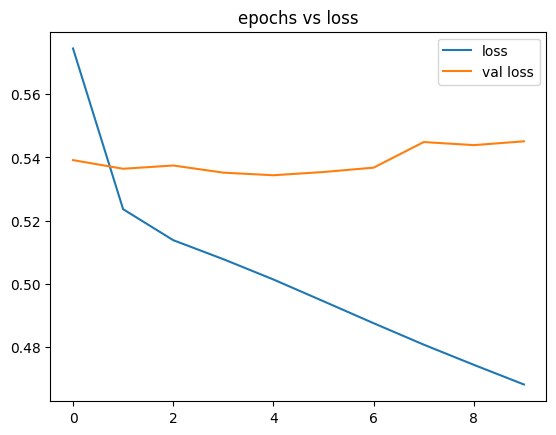

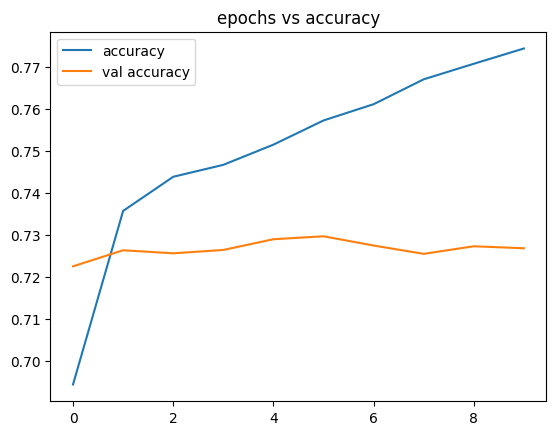

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epoch = history.epoch

plt.plot(epoch,loss, label='loss')
plt.plot(epoch, val_loss, label='val loss')
plt.legend()
plt.title('epochs vs loss')
plt.show()

plt.plot(epoch,acc, label='accuracy')
plt.plot(epoch, val_acc, label='val accuracy')
plt.legend()
plt.title('epochs vs accuracy')
plt.savefig('g3.png')

plt.show()

40/40 [==============================] - 40s 889ms/step


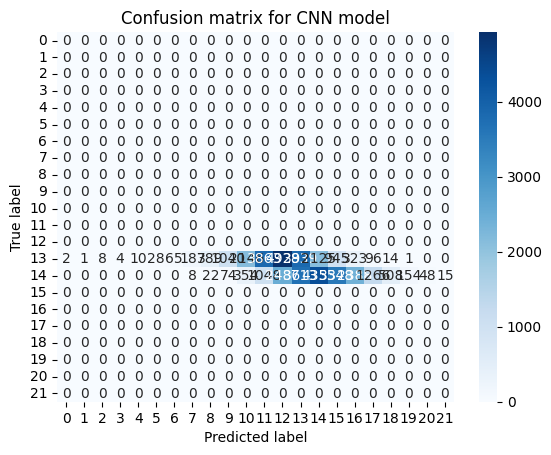

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
batch_size = 1024
y_preds = model3.predict(testing_padded, batch_size=batch_size).round().astype(int)

# Compute the confusion matrix
cm = confusion_matrix(testing_labels, y_preds)

# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix for CNN model')
plt.savefig('confusion_matrix3.png')

# Show the plot
plt.show()

40/40 [==============================] - 3s 67ms/step


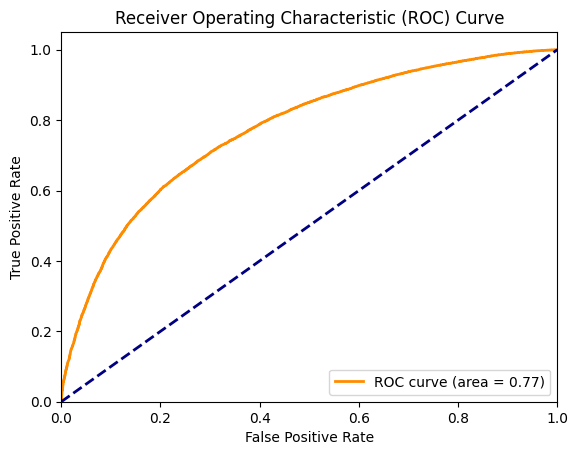

In [35]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the test set
y_prob = model1.predict(testing_padded, batch_size=batch_size)

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(testing_labels, y_prob[:, 0])

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc3.png')
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score
print("Test accuracy score", sklearn.metrics.accuracy_score(y_test, y_preds))
print('Precision= ',sklearn.metrics.precision_score(y_test, y_preds, average=None))
print('Recall= ',sklearn.metrics.recall_score(y_test, y_preds, average=None))
print('F1 score= ',sklearn.metrics.f1_score(y_test, y_preds, average=None))

# Predict probabilities for the test set
y_prob = model1.predict(testing_padded, batch_size=batch_size)

# Calculate AUC
roc_auc = roc_auc_score(testing_labels, y_prob[:, 0])

print('auc= ',roc_auc)

Test accuracy score 0.2048
Precision=  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.50834216 0.67196666 0.         0.         0.
 0.         0.         0.         0.        ]
Recall=  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.19180615 0.21781336 0.         0.         0.
 0.         0.         0.         0.        ]
F1 score=  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.27852142 0.32898764 0.         0.         0.
 0.         0.         0.         0.        ]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


40/40 [==============================] - 4s 92ms/step
auc=  0.7731250761328552


In [37]:
# BERT
from transformers import BertTokenizer
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
def input_for_bert_model(df, tokenizer, max_seq_length):
    columns_list = df.columns.tolist()
    input_ids = np.zeros((len(df), max_seq_length))
    input_attention_masks = np.zeros((len(df), max_seq_length))

    if 'sarcasm_class' in columns_list:
        train_labels = np.zeros((len(df), 1))
        for i, labels in enumerate(df['sarcasm_class']):
            train_labels[i,:] = labels

    for i, sequence in enumerate(df['cleaned_text']):
        tokens = tokenizer.encode_plus(
            sequence,
            max_length = max_seq_length, # max length of the text that can go to BERT
            truncation=True, padding='max_length',
            add_special_tokens = True, # add [CLS], [SEP]
            return_token_type_ids = False,
            return_attention_mask = True, # add attention mask to not focus on pad tokens
            return_tensors = 'tf'
        )
        input_ids[i,:], input_attention_masks[i,:] = tokens['input_ids'], tokens['attention_mask']

    if 'sarcasm_class' in columns_list:
        return input_ids, input_attention_masks, train_labels
    else:
        return input_ids, input_attention_masks

train_ids, train_attention_masks, train_labels = input_for_bert_model(train_dataframe, bert_tokenizer, max_length)
test_ids, test_attention_masks, test_labels = input_for_bert_model(test_dataframe, bert_tokenizer, max_length)
train_inputs = {"input_ids":train_ids[:22895], "attention_mask":train_attention_masks[:22895]}
train_outputs = train_labels[:22895]
valid_inputs = {"input_ids":train_ids[22895:], "attention_mask":train_attention_masks[22895:]}
valid_outputs = train_labels[22895:]
test_inputs = {"input_ids":test_ids, "attention_mask":test_attention_masks}
test_outputs = test_labels[22895:]

In [38]:
#Bert model initialization
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

bert_model = TFBertModel.from_pretrained('bert-base-uncased')
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")
sequence_output = bert_model(input_ids, attention_mask=attention_mask)[0][:,0,:]
x = tf.keras.layers.Dropout(0.1)(sequence_output)
out = tf.keras.layers.Dense(1, activation='linear', name="outputs")(x)
model4 = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=out)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [39]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model4.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history4 = model4.fit(train_inputs, train_outputs, epochs=10, batch_size=8, validation_data=(valid_inputs, valid_outputs))

Epoch 1/10


2862/2862 [==============================] - ETA: 0s - loss: 0.2913 - root_mean_squared_error: 0.5397

ValueError: Expected input data to be non-empty.

In [ ]:
#plotting comparison between 4 models
import pandas as pd
from pandas import DataFrame
accuracy = [max(history1.history['val_accuracy']),max(history2.history['val_accuracy']), max(history3.history['val_accuracy']),max(history4.history['val_accuracy'])]
loss = [max(history1.history['val_loss']),max(history2.history['val_loss']),max(history3.history['val_loss']),max(history4.history['val_loss'])]

col={'Accuracy':accuracy,'Loss':loss}
models=['NN','CNN','LSTM']
graph_df=DataFrame(data=col,index=models)
graph_df

In [ ]:
graph_df.plot(kind='bar')